# Transfer Learning With TenserFlow (Feature Extraction & Fine-Tuning):
# Food Vision 101™ 🍔👁

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images.

we've got the goal of beating [DeepFood](https://https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment), a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

In [60]:
# Import required libraries
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## What we're going to cover

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Building a feature extraction model 
* Fine-tuning the feature extraction model
* Viewing training results on TensorBoard

## Get helper functions

I've created a series of helper functions. Instead of rewriting them (tedious), we'll import the [`helper_functions.py`](https://github.com/zain2525/Transfer-Learning-With-TenserFlow-Feature-Extraction-Fine-Tuning-/blob/main/helper_functions.py)

In [2]:
# Get helper functions file
!wget https://raw.githubusercontent.com/zain2525/Transfer-Learning-With-TenserFlow-Feature-Extraction-Fine-Tuning-/main/helper_functions.py

--2022-10-29 17:51:48--  https://raw.githubusercontent.com/zain2525/Transfer-Learning-With-TenserFlow-Feature-Extraction-Fine-Tuning-/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10224 (10.0K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.98K  --.-KB/s    in 0s      

2022-10-29 17:51:49 (74.6 MB/s) - ‘helper_functions.py’ saved [10224/10224]



In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import plot_loss_curves

## Use TensorFlow Datasets to Download Data

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview).


To begin using TensorFlow Datasets we can import it under the alias `tfds`.

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

To find all of the available datasets in TensorFlow Datasets, you can use the `list_builders()` method.

After doing so, we can check to see if the one we're after (`"food101"`) is present.

In [5]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

True


Beautiful! It looks like the dataset we're after is available (note there are plenty more available but we're on Food101).

To get access to the Food101 dataset from the TFDS, we can use the `tfds.load()` method.

In particular, we'll have to pass it a few parameters to let it know what we're after:
* `name` (str) : the target dataset (e.g. `"food101"`)
* `split` (list, optional) : what splits of the dataset we're after (e.g. `["train", "validation"]`)
  * the `split` parameter is quite tricky. 
* `shuffle_files` (bool) : whether or not to shuffle the files on download, defaults to `False` 
* `as_supervised` (bool) : `True` to download data samples in tuple format (`(data, label)`) or `False` for dictionary format 
* `with_info` (bool) : `True` to download dataset metadata (labels, number of samples, etc)

**Note:** Calling the `tfds.load()` method will start to download a target dataset to disk if the `download=True` parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [6]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteK0OXR6/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteK0OXR6/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


Wonderful! After a few minutes of downloading, we've now got access to entire Food101 dataset (in tensor format) ready for modelling.

Now let's get a little information from our dataset, starting with the class names.

In [7]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the Food101 data from TensorFlow Datasets

Now we've downloaded the Food101 dataset from TensorFlow Datasets.

Let's find out a few details about our dataset:
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the [`.take()` method]) and explore it. 

In [9]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

Because we used the as_supervised=True parameter in our tfds.load() method above, data samples come in the tuple format structure (data, label) or in our case (image_tensor, label).

In [10]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.

In [11]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (384, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 97
  Class name (str form): takoyaki
        


Because we set the shuffle_files=True parameter in our tfds.load() method above, running the cell above a few times will give a different result each time.

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [12]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[ 54,  30,  26],
        [ 57,  33,  29],
        [ 72,  49,  43],
        ...,
        [192, 184, 163],
        [190, 179, 159],
        [181, 169, 147]],

       [[ 51,  28,  22],
        [ 60,  37,  31],
        [ 81,  58,  52],
        ...,
        [191, 183, 162],
        [189, 176, 157],
        [176, 164, 142]],

       [[ 78,  58,  49],
        [ 96,  76,  67],
        [122, 102,  93],
        ...,
        [191, 183, 162],
        [188, 175, 156],
        [172, 157, 136]],

       ...,

       [[162, 140, 117],
        [164, 142, 119],
        [169, 147, 126],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[168, 146, 123],
        [170, 148, 125],
        [176, 154, 131],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[173, 151, 128],
        [176, 154, 131],
        [182, 160, 137],
        ...,
        [  4,   4,   

In [13]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type `unit8`.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

In the meantime, let's see if we can plot an image sample.

### Plot an image from TensorFlow Datasets

We've seen our image tensors in tensor format.

Now let's plot one of the image samples using `matplotlib.pyplot.imshow()` and set the title to target class name.

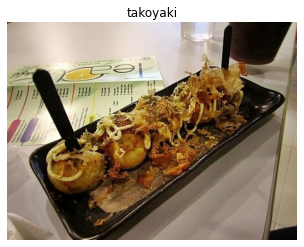

In [14]:
# Plot an image tensor
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

Delicious!

Now let's preprocess it and get it ready for use with a neural network.

## Create preprocessing functions for our data

Since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model. 

More specifically, our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using `tf.image.resize()`
* Converts an input image tensor's current datatype to `tf.float32` using `tf.cast()`

In [15]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

Our preprocess_img() function above takes image and label as input (even though it does nothing to the label) because our dataset is currently in the tuple structure (image, label).

Let's try our function out on a target image.

In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 54  30  26]
  [ 57  33  29]
  [ 72  49  43]
  ...
  [192 184 163]
  [190 179 159]
  [181 169 147]]

 [[ 51  28  22]
  [ 60  37  31]
  [ 81  58  52]
  ...
  [191 183 162]
  [189 176 157]
  [176 164 142]]]...,
Shape: (384, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 56.23469   32.591835  27.877552]
  [ 98.16328   75.16328   68.50001 ]
  [121.62245  101.62245   91.63265 ]
  ...
  [191.72456  191.36736  170.93883 ]
  [202.18863  196.9743   176.90286 ]
  [185.918    174.10167  153.6169  ]]

 [[ 93.47959   73.55102   64.19388 ]
  [144.57143  124.64286  113.561226]
  [169.66327  150.20409  138.79082 ]
  ...
  [196.22955  195.22955  176.80103 ]
  [202.02025  194.9335   175.87225 ]
  [182.24942  168.44324  148.72888 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Excellent! Looks like our preprocess_img() function is working as expected.

The input image gets converted from uint8 to float32 and gets reshaped from its current shape to (224, 224, 3).

How does it look?

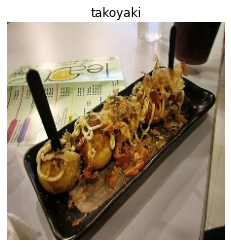

In [17]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

How about we start preparing to model it?

## Batch & prepare datasets

Before we can model our data, we have to turn it into batches.

Why?

Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the `tf.data` API.

In [18]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

And now let's check out what our prepared datasets look like.

In [19]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved).


To do each of these we'll use the following callbacks:
* `tf.keras.callbacks.TensorBoard()` - allows us to keep track of our model's training history so we can inspect it later (**note:** we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* `tf.keras.callbacks.ModelCheckpoint()` - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits


In [20]:
# Create TensorBoard callback (already have "create_tensorboard_callback()"  at helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

## Build feature extraction model

Let's build a model.

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (EfficienetNetBX).

But before we get into fine-tuning, let's set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model) 
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

In [21]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [22]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
# Combine the inputs with the outputs into a model
model = tf.keras.Model(inputs, outputs)


# Check out our model
model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                              

In [23]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

Model ready to go!

We can check this by iterating through our model's layers and printing layer attributes such as dtype and dtype_policy.

In [24]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
pooling_layer True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name` (str) : a layer's human-readable name, can be defined by the `name` parameter on construction
* `layer.trainable` (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's `trainable` attribute to `False`
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in

We can also check the same details for our model's base model.

In [25]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
tf.math.truediv False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">


## Fit the feature extraction model

Now that's one good looking model. Let's fit it to our data shall we?

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [26]:
# Fit the feature extraction model for 5 epochs with tensorboard and model checkpoint callbacks

# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_feature_extract = model.fit(train_data, 
                                    epochs=5,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.15 * len(test_data)),
                                    callbacks=[create_tensorboard_callback("training_logs", 
                                                                          "efficientnetbx_feature_extract"),
                                              model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetbx_feature_extract/20221029-180223
Epoch 1/5
2368/2368 [==============================] - 202s 79ms/step - loss: 1.7142 - accuracy: 0.5836 - val_loss: 1.1152 - val_accuracy: 0.7018
Epoch 2/5
2368/2368 [==============================] - 181s 75ms/step - loss: 1.1987 - accuracy: 0.6890 - val_loss: 1.0256 - val_accuracy: 0.7188
Epoch 3/5
2368/2368 [==============================] - 181s 76ms/step - loss: 1.0534 - accuracy: 0.7235 - val_loss: 1.0008 - val_accuracy: 0.7262
Epoch 4/5
2368/2368 [==============================] - 180s 75ms/step - loss: 0.9589 - accuracy: 0.7476 - val_loss: 0.9762 - val_accuracy: 0.7344
Epoch 5/5
2368/2368 [==============================] - 179s 75ms/step - loss: 0.8888 - accuracy: 0.7649 - val_loss: 0.9772 - val_accuracy: 0.7328


Nice, looks like our feature extraction model is performing pretty well. How about we plot the loss curves & evaluate it on the whole test dataset?

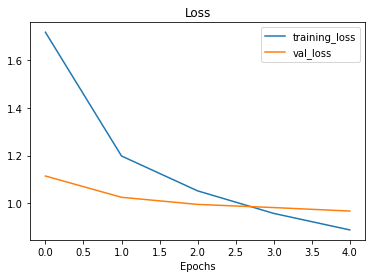

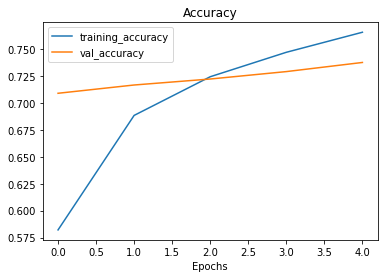

In [ ]:
# Plot the loss curves
# already have "plot_loss_curves()"  at helper_functions.py
plot_loss_curves(history_feature_extract)

## Evaluate the model

In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 57s 71ms/step - loss: 0.9773 - accuracy: 0.7332


[0.9773328304290771, 0.7332277297973633]

Our model results are close to the number we trying to beat ( 77.4%) let's see if we can do this by using `fine-tuning`

## Save the whole model to file

Since our model is quite large, you might want to save it to Google Drive (if you're using Google Colab) so you can load it in for use later.

**Note:** Saving to Google Drive requires mounting Google Drive (go to Files -> Mount Drive).

In [ ]:
# save our model
model.save("/content/drive/MyDrive/Transfer_Learning/Food_Vision_101_model")

In [ ]:
# Load the model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Transfer_Learning/Food_Vision_101_model")

In [ ]:
# Let's get the loaded model summary()
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Evaluate loaded model an compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 60s 75ms/step - loss: 0.9773 - accuracy: 0.7332


[0.9773329496383667, 0.7332277297973633]

In [ ]:
# The results from our loaded_model (above) should be very similer to the results below
results_feature_extract_model

[0.9773328304290771, 0.7332277297973633]

## Preparing our model's layers for fine-tuning

Our feature-extraction model is showing some great promise after five epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data).

Remember our goal of beating the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf)?

They were able to achieve 77.4% top-1 accuracy on Food101 over 2-3 days of training.

I've saved a model I prepared earlier (the feature extraction model from above) to Google Drive.

We can download it.

In [27]:
#Download the saved model from Google Storage
!gdown --id 1Ek990E2WIl1_bSkQWj4ZvsiCVFgtnbK1

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Ek990E2WIl1_bSkQWj4ZvsiCVFgtnbK1
To: /content/Food_Vision_101_model.zip
100% 17.0M/17.0M [00:00<00:00, 29.2MB/s]


In [28]:
# Unzip the model
!mkdir downloaded_gd_model
!mkdir downloaded_gd_model # create separate directory for fine-tuned model downloaded from Google Storage
!unzip Food_Vision_101_model -d downloaded_gd_model

mkdir: cannot create directory ‘downloaded_fine_tuned_gd_model’: File exists
Archive:  Food_Vision_101_model.zip
   creating: downloaded_fine_tuned_gd_model/Food_Vision_101_model/assets/
  inflating: downloaded_fine_tuned_gd_model/Food_Vision_101_model/keras_metadata.pb  
  inflating: downloaded_fine_tuned_gd_model/Food_Vision_101_model/saved_model.pb  
  inflating: downloaded_fine_tuned_gd_model/Food_Vision_101_model/variables/variables.index  
  inflating: downloaded_fine_tuned_gd_model/Food_Vision_101_model/variables/variables.data-00000-of-00001  


Now we can load it using the `tf.keras.models.load_model()` method and get a summary (it should be the exact same as the model we created above).

In [29]:
# Load in fine-tuned model from Google Drive and evaluate
loaded_gd_model = tf.keras.models.load_model("/content/downloaded_fine_tuned_gd_model/Food_Vision_101_model")

In [30]:
# Get a model summary (same model architecture as above)
loaded_gd_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


Finally, we can evaluate our model on the test data (this requires the test_data variable to be loaded).

In [31]:
# Note: Even if you're loading in the model from Google Drive, you will still need to load the test_data variable for this cell to work
results_downloaded_gd_model = loaded_gd_model.evaluate(test_data)
results_downloaded_gd_model

790/790 [==============================] - 56s 69ms/step - loss: 0.9773 - accuracy: 0.7332


[0.977333128452301, 0.7332277297973633]

Great, our loaded model is performing as expected.

When we first created our model, we froze all of the layers in the base model by setting base_model.trainable=False but since we've loaded in our model from file, let's check whether or not the layers are trainable or not.

In [32]:
# Are any of the layers in our model frozen?
for layer in loaded_gd_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "float32">
pooling_layer True float32 <Policy "float32">
output_layer True float32 <Policy "float32">


Alright, it seems like each layer in our loaded model is trainable. But what if we got a little deeper and inspected each of the layers in our base model?

In [33]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gd_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype)

input_1 True float32
rescaling True float32
normalization True float32
tf.math.truediv True float32
stem_conv_pad True float32
stem_conv True float32
stem_bn True float32
stem_activation True float32
block1a_dwconv True float32
block1a_bn True float32
block1a_activation True float32
block1a_se_squeeze True float32
block1a_se_reshape True float32
block1a_se_reduce True float32
block1a_se_expand True float32
block1a_se_excite True float32
block1a_project_conv True float32
block1a_project_bn True float32
block2a_expand_conv True float32
block2a_expand_bn True float32


Wonderful, it looks like each layer in our base model is trainable (unfrozen) 

Since we've got so much data (750 images x 101 training classes = 75750 training images), let's keep all of our base model's layers unfrozen.

**Note:** If you've got a small amount of data (less than 100 images per class), you may want to only unfreeze and fine-tune a small number of layers in the base model at a time. Otherwise, you risk overfitting.

## A couple more callbacks

We're about to start fine-tuning a deep learning model with over 200 layers using over 100,000 (75k+ training, 25K+ testing) images, which means our model's training time is probably going to be much longer than before.

You will really only know how long it'll take once you start training.

Luckily, there's a solution: the `EarlyStopping` callback

The `EarlyStopping` callback monitors a specified model performance metric (e.g. `val_loss`) and when it stops improving for a specified number of epochs, automatically stops training. 

Using the `EarlyStopping` callback combined with the `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Let's set both of these up to monitor our model's `val_loss`.


In [34]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # watch the val loss metric

# Create ModelCheckpoint callback to save best model during fine-tuning   
checkpoint_path = "fine_tune_checkpoints/"  
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")                                         

If you're planning on training large models, the ModelCheckpoint and EarlyStopping are two callbacks you'll want to become very familiar with.

We're almost ready to start fine-tuning our model but there's one more callback we're going to implement: `ReduceLROnPlateau`.

Remember how the learning rate is the most important model hyperparameter you can tune? (if not, treat this as a reminder).

Well, the `ReduceLROnPlateau` callback helps to tune the learning rate for you.

In [35]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 mil_lr=1e-7)

Learning rate reduction ready to go!

Now before we start training, we've got to recompile our model.

We'll use sparse categorical crossentropy as the loss and since we're fine-tuning, we'll use a 10x lower learning rate than the Adam optimizers.

In [36]:
# Compile the model
loaded_gd_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

Okay, model compiled.

Now let's fit it on all of the data.

We'll set it up to run for up to 100 epochs.

Since we're going to be using the EarlyStopping callback, it might stop before reaching 100 epochs.

In [37]:
# Start to fine-tune (all layers)
history_fine_tune = loaded_gd_model.fit(train_data,
                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                        callbacks=[create_tensorboard_callback("training_logs", "efficientnetbx_fine_tuning"), # track the model training logs
                                                   model_checkpoint, # save only the best model during training
                                                   early_stopping, # stop model after X epochs of no improvements
                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientnetbx_fine_tuning/20221029-181932
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7929 - accuracy: 0.7831

2368/2368 [==============================] - 876s 365ms/step - loss: 0.7929 - accuracy: 0.7831 - val_loss: 0.8602 - val_accuracy: 0.7574 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.4723 - accuracy: 0.8676

2368/2368 [==============================] - 854s 360ms/step - loss: 0.4723 - accuracy: 0.8676 - val_loss: 0.8467 - val_accuracy: 0.7704 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 818s 345ms/step - loss: 0.2628 - accuracy: 0.9241 - val_loss: 0.9173 - val_accuracy: 0.7744 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9579
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 799s 337ms/step - loss: 0.1413 - accuracy: 0.9579 - val_loss: 0.9479 - val_accuracy: 0.7836 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 803s 338ms/step - loss: 0.0289 - accuracy: 0.9937 - val_loss: 1.0509 - val_accuracy: 0.7956 - lr: 2.0000e-05


Nice, looks like our fine-tune model is performing pretty well. How about we plot the loss curves & evaluate it on the whole test dataset?

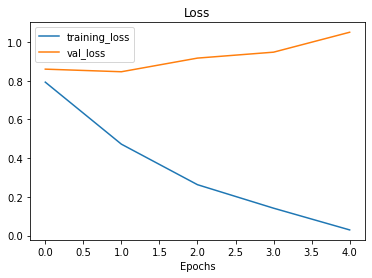

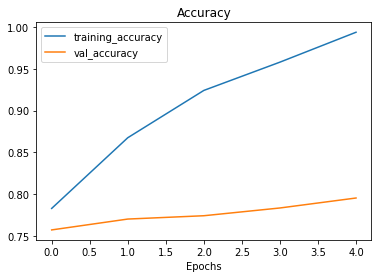

In [38]:
# Plot the loss curves
# already have "plot_loss_curves()"  at helper_functions.py
plot_loss_curves(history_fine_tune)

Looks like our model has gained a few performance points from fine-tuning, let's evaluate on the whole test dataset and see if managed to beat the DeepFood paper's result of 77.4% accuracy.

In [42]:
# Evaluate model on whole test dataset
results_fine_tune_model = loaded_gd_model.evaluate(test_data)
results_fine_tune_model

790/790 [==============================] - 54s 68ms/step - loss: 1.0698 - accuracy: 0.7961


[1.0697582960128784, 0.7961187958717346]

Woohoo!!!! It looks like our model beat the results mentioned in the DeepFood paper for Food101 (DeepFood's 77.4% top-1 accuracy versus our ~79% top-1 accuracy).

## Save the fine-tune model to file

Since our model is quite large, you might want to save it to Google Drive (if you're using Google Colab) so you can load it in for use later.

In [43]:
loaded_gd_model.save("/content/drive/MyDrive/Transfer_Learning/Food_Vision_101_model_fine_tune")

## View training results on TensorBoard

Since we tracked our model's fine-tuning training logs using the `TensorBoard` callback, let's upload them and inspect them on TensorBoard.dev.

In [ ]:
# Upload experiment results to TensorBoard (uncomment to run)
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot

You can view the original versions of the experiments we ran in this notebook here: https://tensorboard.dev/experiment/GbnWXGK3TPmOTxN7kJnZhw/

## Download fine-tuned model from Google drive

As mentioned before, training models can take a significant amount of time.

It's a fine-tuned model exactly like the one we trained above but it's saved to Google Drive so it can be accessed, imported and evaluated

In [44]:
!gdown --id 1x_WsUrXcRx6QN1V46fWSLvLSy2IJOjhY

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1x_WsUrXcRx6QN1V46fWSLvLSy2IJOjhY
To: /content/Food_Vision_101_model_fine_tune.zip
100% 46.8M/46.8M [00:01<00:00, 36.8MB/s]


In [50]:
# Unzip the model
!mkdir downloaded_fine_tuned_gd_model
!mkdir downloaded_fine_tuned_gd_model # create separate directory for fine-tuned model downloaded from Google Storage
!unzip Food_Vision_101_model_fine_tune -d downloaded_fine_tuned_gd_model

mkdir: cannot create directory ‘downloaded_fine_tuned_gd_model’: File exists
mkdir: cannot create directory ‘downloaded_fine_tuned_gd_model’: File exists
Archive:  Food_Vision_101_model_fine_tune.zip
   creating: downloaded_fine_tuned_gd_model/Food_Vision_101_model_fine_tune/assets/
  inflating: downloaded_fine_tuned_gd_model/Food_Vision_101_model_fine_tune/keras_metadata.pb  
  inflating: downloaded_fine_tuned_gd_model/Food_Vision_101_model_fine_tune/variables/variables.index  
  inflating: downloaded_fine_tuned_gd_model/Food_Vision_101_model_fine_tune/saved_model.pb  
  inflating: downloaded_fine_tuned_gd_model/Food_Vision_101_model_fine_tune/variables/variables.data-00000-of-00001  


Now we can load it using the tf.keras.models.load_model() method and get a summary (it should be the exact same as the model we created above).

In [52]:
loaded_fine_tuned_gd_model = tf.keras.models.load_model("/content/downloaded_fine_tuned_gd_model/Food_Vision_101_model_fine_tune")

In [47]:
# Get a model summary (same model architecture as above)
loaded_fine_tuned_gd_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


we can evaluate our model on the test data (this requires the test_data variable to be loaded).

In [53]:
# Note: Even if you're loading in the model from Google Drive, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_gd_model = loaded_fine_tuned_gd_model.evaluate(test_data)
results_downloaded_fine_tuned_gd_model

790/790 [==============================] - 56s 69ms/step - loss: 1.0698 - accuracy: 0.7961


[1.0697587728500366, 0.7961187958717346]

In [49]:
results_fine_tune_model

[1.0697582960128784, 0.7961187958717346]

## Test out the fine-tune loaded model on custom images of food

So far we've visualized some our model's predictions from the test dataset but it's time for the real test: using our model to make predictions on our own custom images of food.

**Note:** You can use the loaded fine-tune model on your images by uploading them to Google Colab or by putting them in a folder you can load into the notebook.

In my case, I've prepared my own small dataset of six or so images of various foods.

Let's download them and unzip them.

**Note:** Even if you're loading in the model from Google Drive, you will still need to load the data variables for this to work.

In [55]:
# Download some custom images from Google Drive
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!gdown --id 19vQOgqKhgh0hPx4trwnafa6KfXCKlyIG

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19vQOgqKhgh0hPx4trwnafa6KfXCKlyIG
To: /content/custom_food_images.zip
100% 13.2M/13.2M [00:00<00:00, 213MB/s]


Unzip the custom images file

In [58]:
from helper_functions import unzip_data, load_and_prep_image

In [57]:
unzip_data("custom_food_images.zip") 

Wonderful, we can load these in and turn them into tensors using our `load_and_prep_image()` function from `helper_functions` but first we need a list of image filepaths.

In [61]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg']

Now we can, make a prediction on each using our trained model and then plot the image along with the predicted class.

1/1 [==============================] - 0s 29ms/step


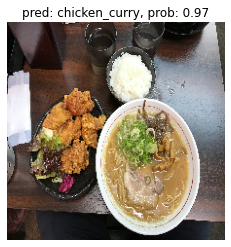

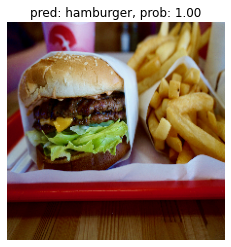

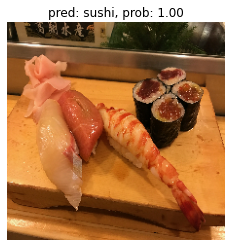

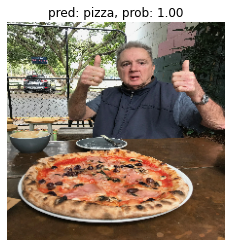

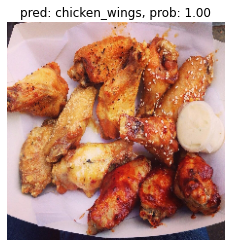

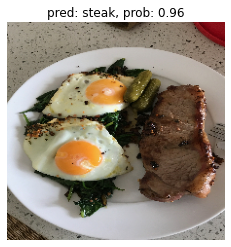

In [62]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = loaded_fine_tuned_gd_model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

How cool is that?! Our Food Vision model has come to life!